# 数据加载及处理

`Ascend` `GPU` `CPU` `入门` `数据准备`

[![在线运行](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tb2RlbGFydHMvcXVpY2tfc3RhcnQvbWluZHNwb3JlX2RhdGFzZXQuaXB5bmI=&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)&emsp;[![下载Notebook](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_dataset.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_dataset.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/dataset.ipynb)

MindSpore提供了部分常用数据集和标准格式数据集的加载接口，用户可以直接使用`mindspore.dataset`中对应的数据集加载类进行数据加载。数据集类为用户提供了常用的数据处理接口，使得用户能够快速进行数据处理操作。

## 数据准备

以下示例代码将数据集下载并解压到指定位置。

In [1]:
import os
import requests
import tarfile
import zipfile

requests.packages.urllib3.disable_warnings()

def download_dataset(url, target_path):
    """下载并解压数据集"""
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    download_file = url.split("/")[-1]
    if not os.path.exists(download_file):
        res = requests.get(url, stream=True, verify=False)
        if download_file.split(".")[-1] not in ["tgz", "zip", "tar", "gz"]:
            download_file = os.path.join(target_path, download_file)
        with open(download_file, "wb") as f:
            for chunk in res.iter_content(chunk_size=512):
                if chunk:
                    f.write(chunk)
    if download_file.endswith("zip"):
        z = zipfile.ZipFile(download_file, "r")
        z.extractall(path=target_path)
        z.close()
    if download_file.endswith(".tar.gz") or download_file.endswith(".tar") or download_file.endswith(".tgz"):
        t = tarfile.open(download_file)
        names = t.getnames()
        for name in names:
            t.extract(name, target_path)
        t.close()
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(url), target_path))

download_dataset("https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz", "./datasets")
download_dataset("https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip", "./datasets")

## 加载数据集

下面的样例通过`Cifar10Dataset`接口加载CIFAR-10数据集，使用顺序采样器获取前5个样本。

In [2]:
import mindspore.dataset as ds

DATA_DIR = "./datasets/cifar-10-batches-bin"
sampler = ds.SequentialSampler(num_samples=5)
dataset = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

## 迭代数据集

用户可以用`create_dict_iterator`创建数据迭代器，迭代访问数据，下面展示了对应图片的形状和标签。

In [3]:
for data in dataset.create_dict_iterator():
    print("Image shape: {}".format(data['image'].shape), ", Label: {}".format(data['label']))

Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 4
Image shape: (32, 32, 3) , Label: 1


## 自定义数据集

对于目前MindSpore不支持直接加载的数据集，可以构造自定义数据集类，然后通过`GeneratorDataset`接口实现自定义方式的数据加载。

In [4]:
import numpy as np

np.random.seed(58)

class DatasetGenerator:
    def __init__(self):
        self.data = np.random.sample((5, 2))
        self.label = np.random.sample((5, 1))

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

其中用户需要自定义的类函数如下：

- **\_\_init\_\_**

    实例化数据集对象时，`__init__`函数被调用，用户可以在此进行数据初始化等操作。

    ```python
    def __init__(self):
        self.data = np.random.sample((5, 2))
        self.label = np.random.sample((5, 1))
    ```

- **\_\_getitem\_\_**

    定义数据集类的`__getitem__`函数，使其支持随机访问，能够根据给定的索引值`index`，获取数据集中的数据并返回。

    其中`__getitem__`函数的返回值，需要是由numpy数组组成的元组（tuple），当返回单个numpy数组时可以写成 `return (np_array_1,)`。

    ```python
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    ```

- **\_\_len\_\_**

    定义数据集类的`__len__`函数，返回数据集的样本数量。

    ```python
    def __len__(self):
        return len(self.data)
    ```

定义数据集类之后，就可以通过`GeneratorDataset`接口按照用户定义的方式加载并访问数据集样本。

In [5]:
dataset_generator = DatasetGenerator()
dataset = ds.GeneratorDataset(dataset_generator, ["data", "label"], shuffle=False)

for data in dataset.create_dict_iterator():
    print('{}'.format(data["data"]), '{}'.format(data["label"]))

[0.36510558 0.45120592] [0.78888122]
[0.49606035 0.07562207] [0.38068183]
[0.57176158 0.28963401] [0.16271622]
[0.30880446 0.37487617] [0.54738768]
[0.81585667 0.96883469] [0.77994068]


## 数据处理及增强

### 数据处理

MindSpore提供的数据集接口具备常用的数据处理方法，用户只需调用相应的函数接口即可快速进行数据处理。

下面的样例先将数据集随机打乱顺序，然后将样本两两组成一个批次。

In [6]:
ds.config.set_seed(58)

# 随机打乱数据顺序
dataset = dataset.shuffle(buffer_size=10)
# 对数据集进行分批
dataset = dataset.batch(batch_size=2)

for data in dataset.create_dict_iterator():
    print("data: {}".format(data["data"]))
    print("label: {}".format(data["label"]))

data: [[0.36510558 0.45120592]
 [0.57176158 0.28963401]]
label: [[0.78888122]
 [0.16271622]]
data: [[0.30880446 0.37487617]
 [0.49606035 0.07562207]]
label: [[0.54738768]
 [0.38068183]]
data: [[0.81585667 0.96883469]]
label: [[0.77994068]]


其中，

`buffer_size`：数据集中进行shuffle操作的缓存区的大小。

`batch_size`：每组包含的数据个数，现设置每组包含2个数据。

### 数据增强

数据量过小或是样本场景单一等问题会影响模型的训练效果，用户可以通过数据增强操作扩充样本多样性，从而提升模型的泛化能力。

下面的样例使用`mindspore.dataset.vision.c_transforms`模块中的算子对MNIST数据集进行数据增强。

导入`c_transforms`模块，加载MNIST数据集。

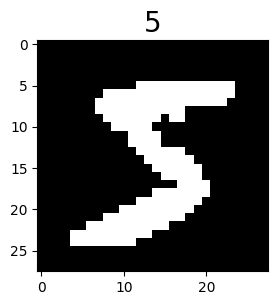

In [7]:
import matplotlib.pyplot as plt

from mindspore.dataset.vision import Inter
import mindspore.dataset.vision.c_transforms as c_vision

DATA_DIR = './datasets/MNIST_Data/train'

mnist_dataset = ds.MnistDataset(DATA_DIR, num_samples=6, shuffle=False)

# 查看数据原图
mnist_it = mnist_dataset.create_dict_iterator()
data = next(mnist_it)
plt.figure(figsize=(3, 3))
plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
plt.title(data['label'].asnumpy(), fontsize=20)
plt.show()

定义数据增强算子，对数据集进行`Resize`和`RandomCrop`操作，然后通过`map`映射将其插入数据处理管道。

In [8]:
resize_op = c_vision.Resize(size=(200, 200), interpolation=Inter.LINEAR)
crop_op = c_vision.RandomCrop(150)
transforms_list = [resize_op, crop_op]
mnist_dataset = mnist_dataset.map(operations=transforms_list, input_columns=["image"])

查看数据增强效果。

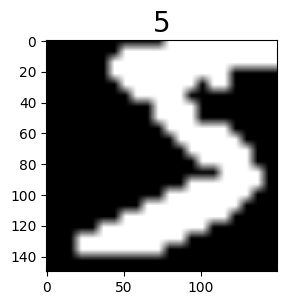

In [9]:
mnist_dataset = mnist_dataset.create_dict_iterator()
data = next(mnist_dataset)
plt.figure(figsize=(3, 3))
plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
plt.title(data['label'].asnumpy(), fontsize=20)
plt.show()

想要了解更多可以参考编程指南中[数据增强](https://www.mindspore.cn/docs/programming_guide/zh-CN/master/augmentation.html)章节。